In [2]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from sksurv.ensemble import RandomSurvivalForest
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [3]:
df = pd.read_csv('data/processed_pancan_pca.csv')

print(f"Data Shape: {df.shape}")

Data Shape: (10952, 3399)


In [4]:
# ==========================================
# PREPARE FEATURES (X) AND TARGET (y)
# ==========================================
# Drop the ID and Targets from the input features
X = df.drop(columns=['sample', 'OS', 'OS.time'])

# Construct the structured target array required by scikit-survival
# Format: List of tuples (Status: bool, Time: float)
y = np.array(
    list(zip(df['OS'].astype(bool), df['OS.time'])),
    dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
)

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

Features (X): (10952, 3396)
Target (y): (10952,)


In [5]:
# SPLIT TRAIN / TEST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y['Status']
)

In [6]:
# Naive check to ensure stratification worked
# n_estimators=100: Create 100 trees
# min_samples_leaf=15: Prevents overfitting by ensuring leaf nodes aren't too small
rsf = RandomSurvivalForest(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=15,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

rsf.fit(X_train, y_train)
print("Training Complete!")

Training Complete!


In [7]:
# ==========================================
# EVALUATION
# ==========================================
# Predict risk scores (higher score = lower survival probability)
print("Evaluating on Test Set...")
scores = rsf.predict(X_test)

# Calculate C-Index
c_index = concordance_index_censored(
    y_test['Status'], 
    y_test['Survival_in_days'], 
    scores
)[0]

print(f"\n==========================================")
print(f"RSF C-INDEX: {c_index:.4f}")
print(f"==========================================")

importances = pd.Series(
    data=0, 
    index=X.columns
)

Evaluating on Test Set...

RSF C-INDEX: 0.7246


In [8]:
def objective(trial):
    """
    Optuna optimization function. 
    It defines the search space, trains the model, and returns the C-Index.
    """
    
    # --- A. Define Hyperparameter Search Space ---
    params = {
        # Number of trees: More is better but slower. 100-500 is a good range.
        'n_estimators': trial.suggest_int('n_estimators', 100, 300, step=50),
        
        # Depth: Controls how complex each tree can get. 
        # Too deep = Overfitting, Too shallow = Underfitting.
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        
        # Min samples to split: Higher values prevent the tree from learning noise.
        'min_samples_split': trial.suggest_int('min_samples_split', 10, 60),
        
        # Min samples in leaf: Guarantees a minimum cluster size at the end.
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 30),
        
        # Max Features: How many features to check at each split.
        # 'sqrt' is standard, 'log2' is faster.
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }
    
    # --- B. Train Model ---
    rsf = RandomSurvivalForest(
        **params,
        n_jobs=-1,        # Use all CPU cores
        random_state=42,  # Deterministic results for this trial
        verbose=0         # Silence the training logs
    )
    
    rsf.fit(X_train, y_train)
    
    # --- C. Evaluate ---
    scores = rsf.predict(X_test)
    c_index = concordance_index_censored(
        y_test['Status'], 
        y_test['Survival_in_days'], 
        scores
    )[0]
    
    return c_index

In [9]:
# direction='maximize' because higher C-Index is better
study = optuna.create_study(direction='maximize', study_name="RSF_Optimization")

# n_trials=20: Runs 20 different combinations. 
study.optimize(objective, n_trials=20)

print("\n==========================================")
print(f"Best C-Index Found: {study.best_value:.4f}")
print("Best Parameters:")
print(study.best_params)
print("==========================================")

[I 2026-01-21 00:46:29,581] A new study created in memory with name: RSF_Optimization
[I 2026-01-21 01:01:32,335] Trial 0 finished with value: 0.7275412036691774 and parameters: {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 35, 'min_samples_leaf': 23, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7275412036691774.
[I 2026-01-21 01:06:46,497] Trial 1 finished with value: 0.6457851691649887 and parameters: {'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 44, 'min_samples_leaf': 28, 'max_features': 'log2'}. Best is trial 0 with value: 0.7275412036691774.
[I 2026-01-21 01:11:11,434] Trial 2 finished with value: 0.6416896611728441 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 60, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 0 with value: 0.7275412036691774.
[I 2026-01-21 01:55:21,346] Trial 3 finished with value: 0.7229684043055659 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 26, 


Best C-Index Found: 0.7427
Best Parameters:
{'n_estimators': 250, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 30, 'max_features': 'sqrt'}


C:\Users\orian\AppData\Local\Temp\ipykernel_1748\880051090.py:2: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


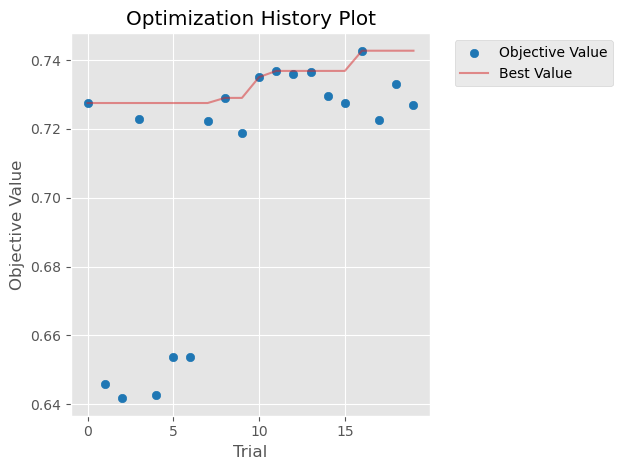

C:\Users\orian\AppData\Local\Temp\ipykernel_1748\880051090.py:6: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


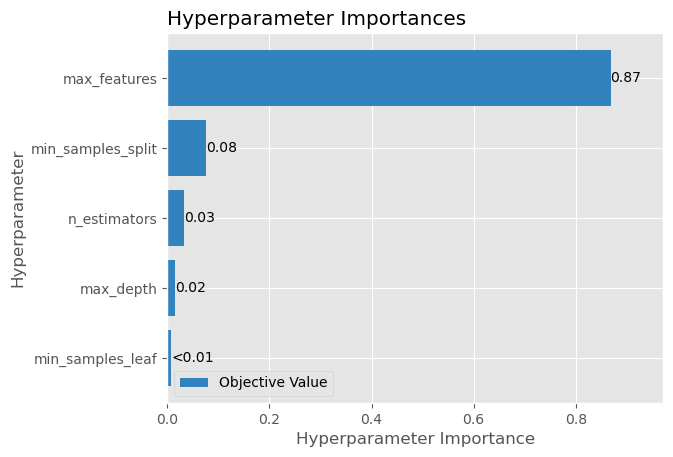

In [10]:
# 1. Shows if the model is improving over time
plot_optimization_history(study)
plt.show()  

# 2. Shows which parameter had the biggest impact
plot_param_importances(study)
plt.show()

In [11]:
print("Best C-Index:", round(study.best_value, 4))
print("Best Params:", study.best_params)

Best C-Index: 0.7427
Best Params: {'n_estimators': 250, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 30, 'max_features': 'sqrt'}


In [13]:
# Train the Best Random Survival Forest (Baseline Model)
# Using the optimal hyperparameters found by Optuna

# Initialize the RSF model with the best parameters
best_rsf = RandomSurvivalForest(
    **study.best_params,
    n_jobs=-1,
    random_state=42
)

# Fit the model on the full training set
best_rsf.fit(X_train, y_train)

# Evaluate baseline performance on the test set using C-index
base_cindex = best_rsf.score(X_test, y_test)
print(f"Baseline RSF Test C-Index: {base_cindex:.4f}")


Baseline RSF Test C-Index: 0.7427


In [15]:
# Permutation Feature Importance
# Measures how much each feature contributes to model performance


from sklearn.inspection import permutation_importance
import pandas as pd

# Compute permutation importance on the test set
result = permutation_importance(
    best_rsf,
    X_test,
    y_test,
    n_repeats=10,           # Number of permutations per feature
    random_state=42,
    n_jobs=1
)

# Create a DataFrame with mean and standard deviation of importance
features_df = pd.DataFrame({
    "Feature": X_test.columns,
    "ImportanceMean": result.importances_mean,
    "ImportanceStd": result.importances_std
}).sort_values("ImportanceMean", ascending=False)

# Display the top 20 most important features
features_df.head(20)


,Feature,ImportanceMean,ImportanceStd
0,age_scaled,0.016997,0.002255
2,ajcc_pathologic_tumor_stage_encoded,0.011353,0.001383
1,cancer type abbreviation_encoded,0.011071,0.001789
27,PCA_22,0.005468,0.001187
9,PCA_4,0.005394,0.000871
26,PCA_21,0.005032,0.001256
20,PCA_15,0.004843,0.001339
12,PCA_7,0.003685,0.000817
21,PCA_16,0.003471,0.001277
34,PCA_29,0.003228,0.000792


In [19]:
features_df.to_csv("permutation_importance.csv", index=False)

In [16]:
# =========================================================
# Feature Selection
# Select the top-K most important features based on permutation importance
# =========================================================

K = 100  # Number of features to keep
selected_features = features_df.head(K)["Feature"].tolist()

print(f"Selected {len(selected_features)} features out of {X_train.shape[1]}")


Selected 100 features out of 3396


In [17]:
# =========================================================
# Train Refined Random Survival Forest
# Using only the selected top-K features
# =========================================================

# Reduce training and test sets to selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Initialize a new RSF model with the same optimal hyperparameters
refined_rsf = RandomSurvivalForest(
    **study.best_params,
    n_jobs=1,
    random_state=42
)

# Train the refined model
refined_rsf.fit(X_train_selected, y_train)

# Evaluate refined model performance
refined_cindex = refined_rsf.score(X_test_selected, y_test)

print(f"Baseline Test C-Index: {base_cindex:.4f}")
print(f"Refined  Test C-Index: {refined_cindex:.4f}")
print(f"Performance Difference (Delta): {refined_cindex - base_cindex:.4f}")


Baseline Test C-Index: 0.7427
Refined  Test C-Index: 0.7827
Performance Difference (Delta): 0.0400


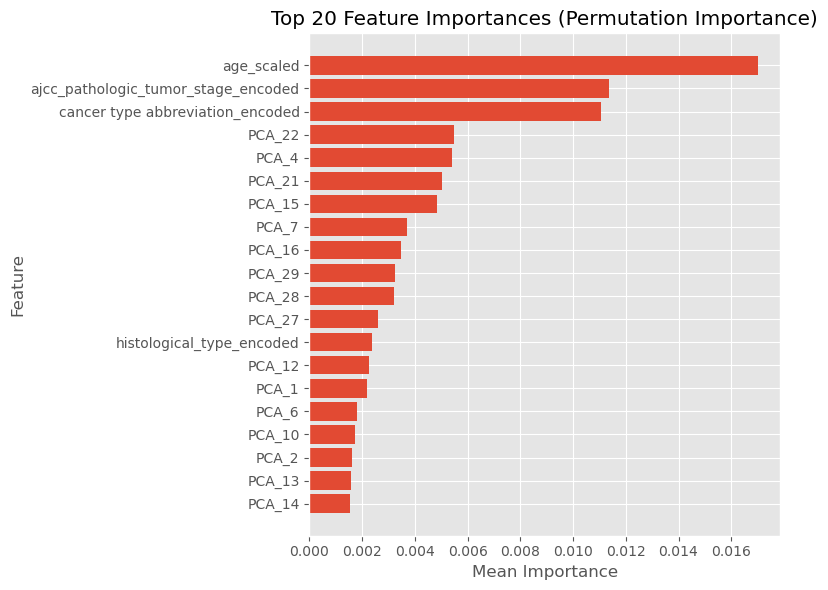

In [18]:
# =========================================================
# Visualization of Top Feature Importances
# =========================================================

top_n = 20
top_features = features_df.head(top_n).iloc[::-1]

plt.figure(figsize=(8, 6))
plt.barh(top_features["Feature"], top_features["ImportanceMean"])
plt.title(f"Top {top_n} Feature Importances (Permutation Importance)")
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [42]:
# Predict risk scores using the refined RSF model
risk_scores = refined_rsf.predict(X_test_selected)

df_eval = pd.DataFrame({
    "time": pd.to_numeric(y_test["Survival_in_days"], errors="coerce"),
    "event": pd.to_numeric(y_test["Status"], errors="coerce").astype(int),
    "risk_score": risk_scores
}).dropna()

# Ensure event is binary
df_eval["event"] = df_eval["event"].clip(0, 1)

print("Samples used:", len(df_eval))
print("Event distribution:")
print(df_eval["event"].value_counts())


Samples used: 2191
Event distribution:
event
0    1535
1     656
Name: count, dtype: int64


In [43]:
# Median split
threshold = df_eval["risk_score"].median()

df_eval["risk_group"] = np.where(
    df_eval["risk_score"] > threshold, "High risk", "Low risk"
)

print(df_eval["risk_group"].value_counts())

low_mask = df_eval["risk_group"] == "Low risk"
high_mask = df_eval["risk_group"] == "High risk"


risk_group
Low risk     1096
High risk    1095
Name: count, dtype: int64


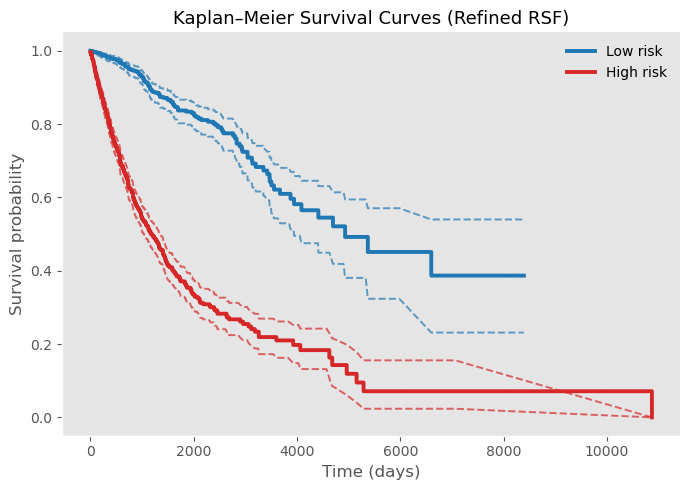

In [48]:
# Kaplan–Meier curves (clean & simple)

kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(7, 5))

colors = {"Low risk": "#1f77b4", "High risk": "#d62728"}

for group, mask in [("Low risk", low_mask), ("High risk", high_mask)]:
    kmf.fit(
        df_eval.loc[mask, "time"],
        event_observed=df_eval.loc[mask, "event"],
        label=group
    )

    # Main KM curve (solid line)
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        linewidth=2.8,
        color=colors[group]
    )

    # Confidence intervals as dashed lines
    ci = kmf.confidence_interval_
    ax.plot(ci.index, ci.iloc[:, 0], "--", color=colors[group], linewidth=1.4, alpha=0.7)
    ax.plot(ci.index, ci.iloc[:, 1], "--", color=colors[group], linewidth=1.4, alpha=0.7)

ax.set_title("Kaplan–Meier Survival Curves (Refined RSF)", fontsize=13)
ax.set_xlabel("Time (days)")
ax.set_ylabel("Survival probability")
ax.grid(True, alpha=0.15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(frameon=False)

plt.tight_layout()
plt.show()


In [49]:
lr = logrank_test(
    df_eval.loc[low_mask, "time"],
    df_eval.loc[high_mask, "time"],
    event_observed_A=df_eval.loc[low_mask, "event"],
    event_observed_B=df_eval.loc[high_mask, "event"]
)

print("Log-rank test results:")
print(f"Test statistic: {lr.test_statistic:.4f}")
print(f"P-value:        {lr.p_value:.3g}")


Log-rank test results:
Test statistic: 400.8759
P-value:        3.55e-89
